## Preamble

### Project Template

In [1]:
%load_ext autoreload

In [2]:
import os as _os

_os.chdir(_os.environ["PROJECT_ROOT"])
_os.path.realpath(_os.path.curdir)

'/pollard/data/projects/bsmith/strain-corr'

### Imports

In [3]:
import os
import subprocess
import sys
import time
from datetime import datetime
from glob import glob
from itertools import chain, product
from tempfile import mkstemp

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm

import lib.plot
from lib.pandas_util import align_indexes, aligned_index, idxwhere, invert_mapping

## Style

In [4]:
sns.set_context("paper")
plt.rcParams["figure.dpi"] = 300

# Load and Check Data

In [5]:
genome_list = idxwhere(
    pd.read_table("meta/genome_group.tsv", index_col="genome_id").genome_group_id
    == "xjin"
)
len(genome_list)

125

In [6]:
genome = pd.read_table("meta/genome.tsv", index_col="genome_id").loc[genome_list]
assert genome.index.is_unique
genome = genome.loc[genome_list][lambda x: x.species_id != "UNKNOWN"]

In [7]:
species_list = genome.species_id.unique()
genome.species_id.value_counts().agg(["sum", "count"])

sum      105
count     95
Name: count, dtype: int64

### Taxonomy

In [8]:
def parse_taxonomy_string(taxonomy_string):
    values = taxonomy_string.split(";")
    return pd.Series(values, index=["d__", "p__", "c__", "o__", "f__", "g__", "s__"])

In [9]:
species_taxonomy_inpath = "ref/uhgg_genomes_all_v2.tsv"

species_taxonomy = (
    pd.read_table(species_taxonomy_inpath)[lambda x: x.Genome == x.Species_rep]
    .assign(species_id=lambda x: "1" + x.MGnify_accession.str.split("-").str[2])
    .set_index("species_id")
    .Lineage.apply(parse_taxonomy_string)
)
species_taxonomy.loc[species_list]

/tmp/bsmith/ipykernel_4131335/29604530.py:4: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_table(species_taxonomy_inpath)[lambda x: x.Genome == x.Species_rep]


,d__,p__,c__,o__,f__,g__,s__
species_id,,,,,,,
100901,d__Bacteria,p__Firmicutes_C,c__Negativicutes,o__Acidaminococcales,f__Acidaminococcaceae,g__Acidaminococcus,s__Acidaminococcus fermentans
101440,d__Bacteria,p__Firmicutes_C,c__Negativicutes,o__Acidaminococcales,f__Acidaminococcaceae,g__Acidaminococcus,s__Acidaminococcus intestini
102480,d__Bacteria,p__Actinobacteriota,c__Coriobacteriia,o__Coriobacteriales,f__Eggerthellaceae,g__Adlercreutzia,s__Adlercreutzia equolifaciens
102454,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Verrucomicrobiales,f__Akkermansiaceae,g__Akkermansia,s__Akkermansia muciniphila
101830,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Rikenellaceae,g__Alistipes,s__Alistipes finegoldii
...,...,...,...,...,...,...,...
103682,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Ruthenibacterium,s__Ruthenibacterium lactatiformans
100143,d__Bacteria,p__Firmicutes,c__Bacilli,o__Haloplasmatales,f__Turicibacteraceae,g__Turicibacter,s__Turicibacter sanguinis
100148,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Tyzzerella,s__Tyzzerella nexilis


In [10]:
species_taxonomy.loc[species_list].p__.value_counts()

p__
p__Firmicutes_A          39
p__Bacteroidota          28
p__Firmicutes            10
p__Firmicutes_C           7
p__Actinobacteriota       7
p__Desulfobacterota_A     2
p__Verrucomicrobiota      1
p__Proteobacteria         1
Name: count, dtype: int64

p__Euryarchaeota (0.49999999999999956, 0.0, 1.0)
p__Thermoplasmatota (0.4762434743766357, 0.43561560482888373, 0.8118718682762947)
p__Firmicutes (0.13730663956330513, 0.48846903076532633, 1.0)
p__Firmicutes_A (0.2313124726048037, 0.5864780640600611, 0.6939374178144111)
p__Firmicutes_C (0.03269207045110534, 0.9999999999999998, 1.0)
p__Actinobacteriota (0.4723724756649227, 0.8241241585549742, 0.7293059019107313)
p__Synergistota (0.5039025959761778, 1.0, 0.7049219497439101)
p__Fusobacteriota (0.7159995965199522, 0.8931657578847765, 0.6794972736543294)
p__Campylobacterota (0.9433756729740642, 1.0, 0.3660254037844388)
p__Proteobacteria (0.8446027625105776, 0.6948742813072231, 0.5338082875317327)
p__Desulfobacterota_A (0.9999999999999999, 0.49465584339977886, 0.25584277759443574)
p__Bacteroidota (0.7822498041325509, 0.4101711929297688, 0.34674941239765256)
p__Verrucomicrobiota (1.0, 0.0, 0.0)


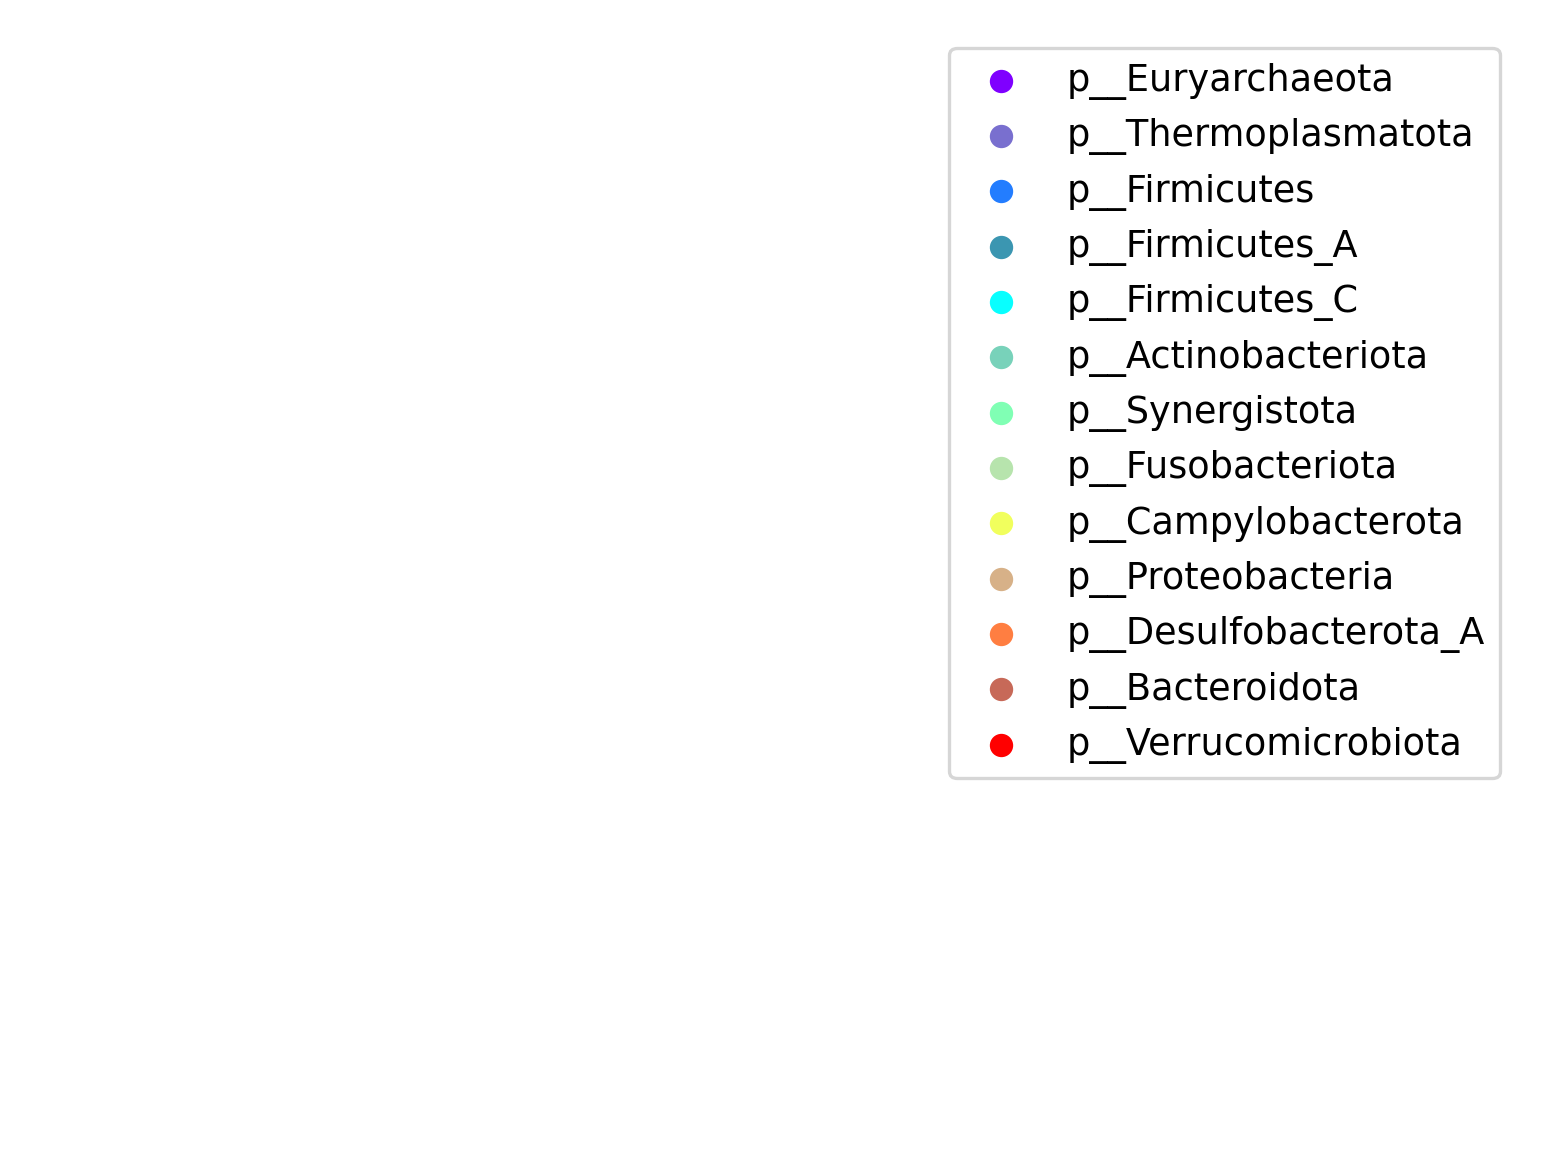

In [11]:
phylum_order = [
    "p__Euryarchaeota",
    "p__Thermoplasmatota",
    "p__Firmicutes",
    "p__Firmicutes_A",
    "p__Firmicutes_C",
    # "p__Firmicutes_B", # None in species_list1
    # "p__Firmicutes_G", # B/G/I not sure how related to C or A
    # "p__Firmicutes_I", #
    # "p__Cyanobacteria", # None in species_list1
    "p__Actinobacteriota",
    "p__Synergistota",
    "p__Fusobacteriota",
    "p__Campylobacterota",
    "p__Proteobacteria",
    "p__Desulfobacterota_A",
    "p__Bacteroidota",
    "p__Verrucomicrobiota",
    # "dummy0", # 18
    # "dummy1", # 19
    # "dummy2", # 20
]

phylum_palette = lib.plot.construct_ordered_palette(
    phylum_order,
    cm="rainbow",
    desaturate_levels=[1.0, 0.5],
)

for p__ in phylum_order:
    print(p__, phylum_palette[p__])
    plt.scatter([], [], color=phylum_palette[p__], label=p__)
plt.legend(ncols=1)
lib.plot.hide_axes_and_spines()

# assert len(set(phylum_palette.values())) == len((phylum_palette.values()))

In [12]:
species_group = (
    pd.read_table("meta/species_group.tsv")[lambda x: x.species_group_id == "xjin"]
    .species_id.astype(str)
    .to_list()
)
len(species_group)

627

In [13]:
qc_code_meaning = {
    -1: "fail",
    0: "passes",
    1: "noise",
    2: "species-gene",
    3: "both",
}


def assign_qc_code(x):
    if x.passes_species_gene_frac:
        if x.passes_log_selected_gene_depth_ratio_std:
            return 0  # Nothing wrong
        else:
            return 1  # Doesn't pass noise threshold
    elif x.passes_log_selected_gene_depth_ratio_std:
        return 2  # Doesn't pass species_gene_frac
    else:
        return 3  # Doesn't pass either

In [14]:
# data/group/xjin/r.proc.gtpro.sfacts-fit.gene99_v15-v22-agg75.spgc_specgene-ref-t25-p95.STRAIN_MATCH_BENCHMARK_GRID.flag

strain_match = {}
missing = []
for species in species_list:
    if species == "UNKNOWN":
        continue
    strain_diss_path = f"data/group/xjin/species/sp-{species}/r.proc.gtpro.sfacts-fit.geno_matching_stats.tsv"
    strain_meta_path = f"data/group/xjin/species/sp-{species}/r.proc.gtpro.sfacts-fit.gene99_v20-v23-agg75.spgc-fit.strain_meta-s95-d100-a0-pos100-std25.tsv"
    if not os.path.exists(strain_diss_path):
        missing.append(strain_diss_path)
        continue
    strain_meta = pd.read_table(strain_meta_path, index_col="genome_id").rename_axis(
        "strain"
    )
    strain_match[species] = (
        pd.read_table(strain_diss_path, index_col=["genome_id", "strain"])
        # .assign(
        #     genotype_matching_positions=lambda x: (1 - x.genotype_dissimilarity)
        #     * x.num_geno_positions_compared,
        #     genotype_dissimilarity_pc=lambda x: x.genotype_dissimilarity
        #     + (1 / x.num_geno_positions_compared),
        #     strain_match_path=strain_match_path,
        # )
        .join(strain_meta, on="strain")
    )
strain_match = (
    pd.concat(strain_match.values()).reset_index().set_index(["genome_id", "strain"])
).assign(qc_code=lambda x: x.apply(assign_qc_code, axis=1))
strain_match

,,genotype_dissimilarity,num_gene,num_strain_sample,sum_strain_depth,max_strain_depth,species_gene_frac,log_selected_gene_depth_ratio_std,num_geno_positions,strain_metagenotype_entropy,genome_type,gene_count_score,passes_total_depth,passes_species_gene_frac,passes_gene_count,passes_log_selected_gene_depth_ratio_std,passes_geno_positions,passes_filter,qc_code
genome_id,strain,,,,,,,,,,,,,,,,,,
Acidaminococcus-fermentans-DSM-20731_MAF-2,4,0.000024,2555,265,6397.953119,139.003780,0.998187,0.155767,44231,0.003515,SPGC,0.449999,True,True,True,True,True,True,0
Acidaminococcus-intestini-D21_MAF-2,2,0.000073,2523,276,50640.505200,458.756957,0.997600,0.170361,13820,0.003386,SPGC,0.495788,True,True,True,True,True,True,0
Adlercreutzia-equolifaciens-DSM-19450_NCBI,5,0.000024,2729,39,7.935227,1.834346,0.985879,0.192060,83381,0.004071,SPGC,0.411532,True,True,True,True,True,True,0
Akkermansia-muciniphila-ATCC-BAA-835_MAF-2,6,0.000012,2372,104,17.642777,0.794083,0.919321,0.200317,81147,0.001398,SPGC,NaN,True,False,False,True,True,False,2
Alistipes-finegoldii-DSM-17242_NCBI,1,0.000168,3535,227,90.087915,1.620729,0.975894,0.204032,6027,0.001786,SPGC,0.495406,True,True,True,True,True,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Turicibacter-sanguinis-DSM-14220_MAF-2,3,0.666667,0,2,0.000000,0.000000,0.000000,NaN,2,0.000000,SPGC,NaN,False,False,False,False,False,False,3
Tyzzerella-nexilis-DSM-1787_MAF-2,0,0.000426,2821,120,58.982587,3.954721,0.988803,0.191560,35214,0.004879,SPGC,0.216358,True,True,True,True,True,True,0
Veillonella-dispar-ATCC-17748_MAF-2,2,0.000036,1889,34,65.499586,6.380582,0.986763,0.251370,28842,0.003574,SPGC,0.390626,True,True,True,False,True,False,1


,strain,genotype_dissimilarity,num_gene,num_strain_sample,sum_strain_depth,max_strain_depth,species_gene_frac,log_selected_gene_depth_ratio_std,num_geno_positions,strain_metagenotype_entropy,genome_type,gene_count_score,passes_total_depth,passes_species_gene_frac,passes_gene_count,passes_log_selected_gene_depth_ratio_std,passes_geno_positions,passes_filter,qc_code
genome_id,,,,,,,,,,,,,,,,,,,
Clostridium-sporogenes-ATCC-15579_MinIONHybrid,0,0.000007,3484,275,9081.916832,205.624044,1.000000,0.174993,142480,0.001474,SPGC,0.400753,True,True,True,True,True,True,0
Prevotella-buccalis-ATCC-35310_MAF-2,0,0.000008,2113,39,54.857037,10.714180,1.000000,0.122376,127988,0.001625,SPGC,0.364008,True,True,True,True,True,True,0
Megasphaera-DSMZ-102144_MinIONHybrid,2,0.000008,2243,276,3881.976043,50.644082,1.000000,0.109271,128409,0.001491,SPGC,0.429363,True,True,True,True,True,True,0
Mitsuokella-multacida-DSM-20544_MAF-2,0,0.000012,2562,276,11953.978608,129.723086,0.998963,0.156316,90345,0.001714,SPGC,0.445829,True,True,True,True,True,True,0
Akkermansia-muciniphila-ATCC-BAA-835_MAF-2,6,0.000012,2372,104,17.642777,0.794083,0.919321,0.200317,81147,0.001398,SPGC,NaN,True,False,False,True,True,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Anaerobutyricum-hallii-DSM-3353_MAF-2,21,0.333333,0,2,0.000000,0.000000,0.000000,NaN,2,0.000000,SPGC,NaN,False,False,False,False,False,False,3
Bacteroides-vulgatus-ATCC-8482_NCBI,3,0.467949,4570,36,1609.779785,101.826362,0.986667,0.208964,191,0.005707,SPGC,0.447905,True,True,True,True,True,True,0
Blautia-wexlerae-DSM-19850_MAF-2,0,0.500000,0,2,0.000000,0.000000,0.000000,NaN,2,0.000000,SPGC,NaN,False,False,False,False,False,False,3


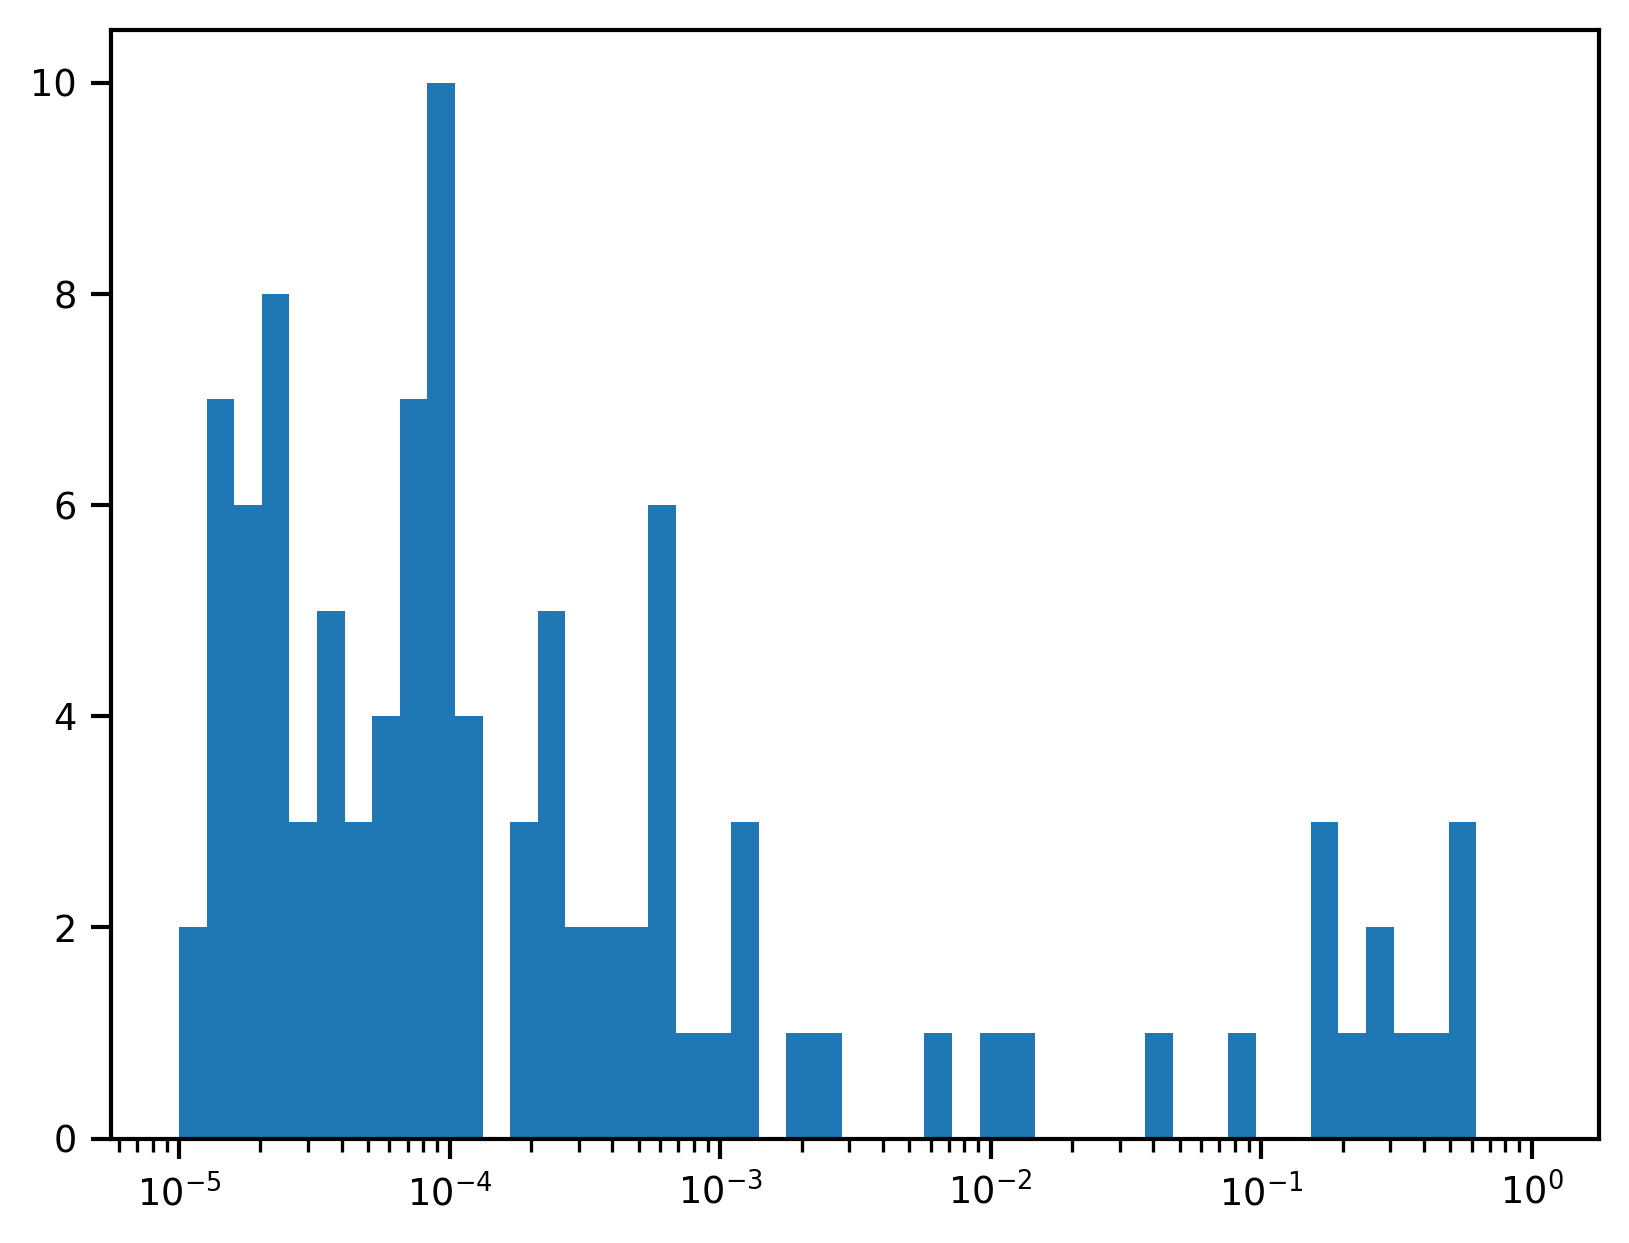

In [15]:
# NOTE: We match strains based on the lowest genotype_dissimilarity.
genome_to_spgc_strain = (
    strain_match.reset_index()
    .sort_values(
        ["genotype_dissimilarity", "num_strain_sample"], ascending=(True, False)
    )
    .groupby("genome_id")
    .head(1)
    .set_index("genome_id")
)

plt.hist(genome_to_spgc_strain.genotype_dissimilarity, bins=np.logspace(-5, 0))
plt.xscale("log")

genome_to_spgc_strain

In [16]:
# data/group/xjin/r.proc.gene99_v15-v22-agg75.spgc_specgene-ref-t25-p95.SPECIES_DEPTH_BENCHMARK_GRID.flag
# data/group/xjin/r.proc.gene99_v15-v22-agg75.ACCURACY_BENCHMARK_GRID.flag
# data/group/xjin/r.proc.gene99_v15-v22-agg75.spgc-fit.STRAIN_META_BENCHMARK_GRID.flag

benchmark = {}
depth_meta = {}
spgc_qc = {}
missing = []


for species in species_list:
    for gene_stem in ["gene99_v15-v22-agg75", "gene99_v20-v23-agg75"]:
        depth_path = f"data/group/xjin/species/sp-{species}/r.proc.{gene_stem}.spgc_specgene-ref-filt-p95.species_depth.tsv"
        _depth = pd.read_table(
            depth_path, names=["sample_id", "depth"], index_col="sample_id"
        ).depth
        depth_meta[(species, gene_stem)] = pd.Series(
            dict(species_depth_max=_depth.max(), species_depth_sum=_depth.sum())
        )
        for genome_id, d in genome[lambda x: x.species_id == species].iterrows():
            matched_strain = genome_to_spgc_strain.strain[genome_id]
            spgc_qc_path = f"data/group/xjin/species/sp-{species}/r.proc.gtpro.sfacts-fit.{gene_stem}.spgc-fit.strain_meta-s95-d100-a0-pos100-std25.tsv"
            if os.path.exists(spgc_qc_path):
                qc = pd.read_table(spgc_qc_path, index_col="genome_id")
                if matched_strain in qc.index:
                    spgc_qc[(genome_id, gene_stem)] = qc.loc[matched_strain]

            # SPGC
            for unit in ["uhggtop", "eggnog", "cog"]:
                for tool in [
                    "spgc-fit",
                    # "spgc2-fit",
                    # "nnmatched-m50",
                    # "nnmatched-m10",
                    # "nnmatched-m1",
                    # "nnmatched-m0",
                    "spgc-depth200",
                ]:
                    accuracy_path = f"data/group/xjin/species/sp-{species}/r.proc.{gene_stem}.{tool}.{genome_id}.{unit}-reconstruction_accuracy.tsv"
                    if not os.path.exists(accuracy_path):
                        missing.append(accuracy_path)
                        continue
                    accuracy = (
                        pd.read_table(accuracy_path, index_col="strain")
                        .assign(
                            species=species,
                            accuracy_path=accuracy_path,
                            strain=lambda x: x.index,
                        )
                        .sort_values("f1", ascending=False)
                    )

                    if matched_strain in accuracy.index:
                        benchmark[
                            (genome_id, gene_stem, unit, tool, "match")
                        ] = accuracy.loc[matched_strain]
                    if accuracy.shape[0] >= 1:
                        benchmark[
                            (genome_id, gene_stem, unit, tool, "top")
                        ] = accuracy.iloc[0]
                    if accuracy.shape[0] >= 2:
                        benchmark[
                            (genome_id, gene_stem, unit, tool, "second")
                        ] = accuracy.iloc[1]
                for tool in [
                    "panphlan",
                    # "spanda-s2",
                    # "spanda-s3",
                    # "spanda-s4",
                    # "spanda-s5",
                    "spanda-s6",
                ]:
                    accuracy_path = f"data/group/xjin/species/sp-{species}/r.proc.{gene_stem}.{tool}.{genome_id}.{unit}-reconstruction_accuracy.tsv"
                    if not os.path.exists(accuracy_path):
                        missing.append(accuracy_path)
                        continue
                    accuracy = (
                        pd.read_table(accuracy_path, index_col="strain")
                        .assign(
                            species=species,
                            accuracy_path=accuracy_path,
                            strain=lambda x: x.index,
                        )
                        .sort_values("f1", ascending=False)
                    )
                    if accuracy.shape[0] >= 1:
                        benchmark[
                            (genome_id, gene_stem, unit, tool, "top")
                        ] = accuracy.iloc[0]
                        benchmark[
                            (genome_id, gene_stem, unit, tool, "match")
                        ] = accuracy.iloc[0]
                    if accuracy.shape[0] >= 2:
                        benchmark[
                            (genome_id, gene_stem, unit, tool, "second")
                        ] = accuracy.iloc[1]
                    if accuracy.shape[0] >= 3:
                        benchmark[
                            (genome_id, gene_stem, unit, tool, "third")
                        ] = accuracy.iloc[2]

benchmark = pd.DataFrame(benchmark.values(), index=benchmark.keys()).rename_axis(
    ["genome_id", "gene_stem", "unit", "tool", "match"]
)
depth_meta = pd.DataFrame(depth_meta.values(), index=depth_meta.keys()).rename_axis(
    ["species", "gene_stem"]
)
spgc_qc = pd.DataFrame(spgc_qc.values(), index=spgc_qc.keys()).rename_axis(
    ["genome_id", "gene_stem"]
)
# .assign(
#     qc_code=lambda x: x.apply(assign_qc_code, axis=1)
# )

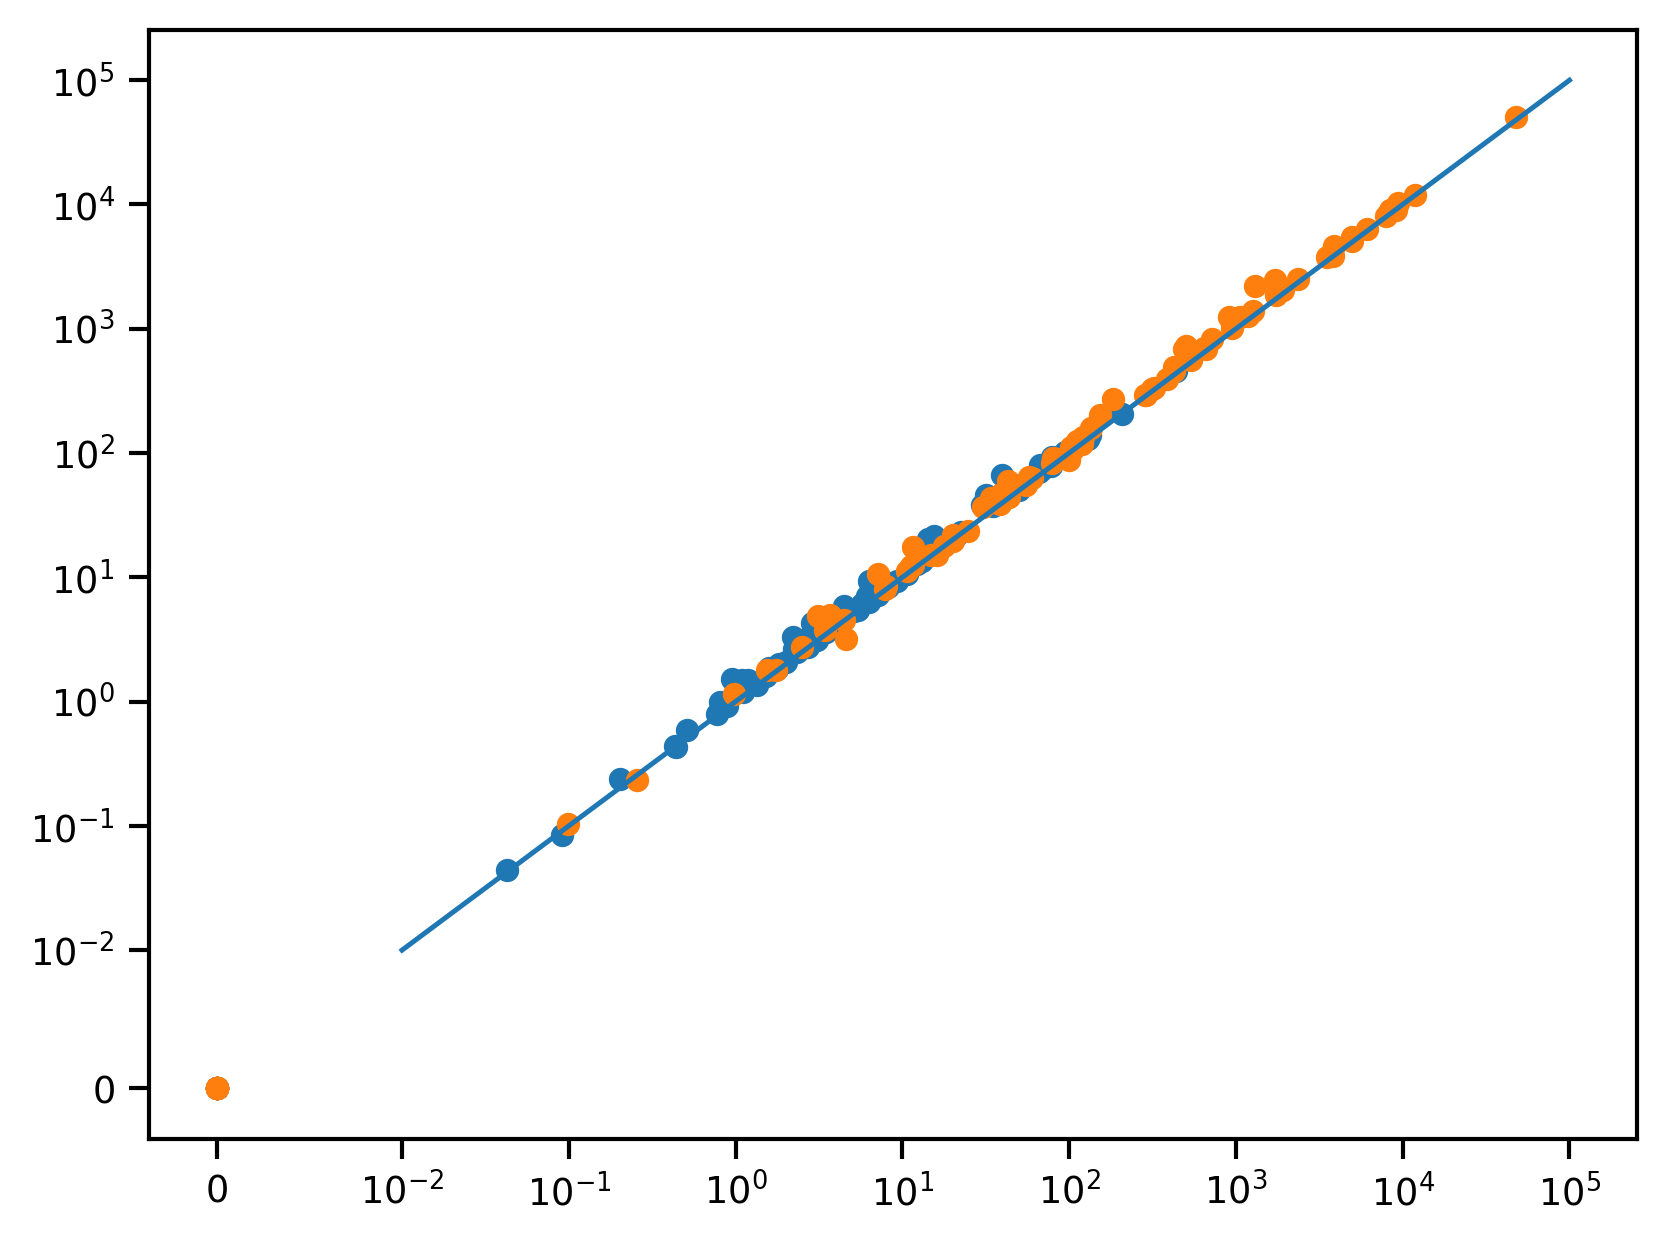

In [17]:
d_max = depth_meta.species_depth_max.unstack()
d_sum = depth_meta.species_depth_sum.unstack()

plt.scatter("gene99_v15-v22-agg75", "gene99_v20-v23-agg75", data=d_max)
plt.scatter("gene99_v15-v22-agg75", "gene99_v20-v23-agg75", data=d_sum)
plt.plot([1e-2, 1e5], [1e-2, 1e5])
plt.xscale("symlog", linthresh=1e-2)
plt.yscale("symlog", linthresh=1e-2)

In [18]:
# How many additional species had _no_ depth whatsoever?

genome.join(depth_meta.xs("gene99_v20-v23-agg75", level="gene_stem"), on="species_id")[
    lambda x: x.species_depth_sum == 0
]

,species_id,genome_path,_old_genome_id,comments,species_depth_max,species_depth_sum
genome_id,,,,,,
Anaerobutyricum-hallii-DSM-3353_MAF-2,100262,raw/genomes/xjin/Anaerobutyricum-hallii-DSM-33...,Anaerobutyricum_hallii_DSM_3353_MAF_2,no xjin samples in metagenotype dataset after ...,0.0,0.0
Blautia-wexlerae-DSM-19850_MAF-2,101338,raw/genomes/xjin/Blautia-wexlerae-DSM-19850_MA...,Blautia_wexlerae_DSM_19850_MAF_2,NaN,0.0,0.0
Clostridium-spiroforme-DSM-1552_MAF-2,101304,raw/genomes/xjin/Clostridium-spiroforme-DSM-15...,Clostridium_spiroforme_DSM_1552_MAF_2,NaN,0.0,0.0
Faecalibacterium-prausnitzii-A2-165_MAF-2,100022,raw/genomes/xjin/Faecalibacterium-prausnitzii-...,Faecalibacterium_prausnitzii_A2_165_MAF_2,no xjin samples in metagenotype dataset after ...,0.0,0.0
Roseburia-inulinivorans-DSM-16841_MAF-2,100271,raw/genomes/xjin/Roseburia-inulinivorans-DSM-1...,Roseburia_inulinivorans_DSM_16841_MAF_2,no xjin samples in metagenotype dataset after ...,0.0,0.0
Ruminococcus-albus-8_MAF-2,102321,raw/genomes/xjin/Ruminococcus-albus-8_MAF-2.fa,Ruminococcus_albus_8_MAF_2,Hits kmers in a variety of species; but domina...,0.0,0.0
Solobacterium-moorei-DSM-22971_MAF-2,100773,raw/genomes/xjin/Solobacterium-moorei-DSM-2297...,Solobacterium_moorei_DSM_22971_MAF_2,Hits kmers in a variety of species; dominated ...,0.0,0.0
Turicibacter-sanguinis-DSM-14220_MAF-2,100143,raw/genomes/xjin/Turicibacter-sanguinis-DSM-14...,Turicibacter_sanguinis_DSM_14220_MAF_2,NaN,0.0,0.0


In [19]:
# And how many had any depth?

genome_filt_list = list(
    genome.join(
        depth_meta.xs("gene99_v20-v23-agg75", level="gene_stem"), on="species_id"
    )[lambda x: (x.species_id != "UNKNOWN") & (x.species_depth_sum > 0)].index
)
species_filt_list = list(genome.loc[genome_filt_list].species_id.unique())

len(genome_filt_list), len(species_filt_list)

(97, 87)

### Number of strains per species after filtering

In [20]:
genome.loc[genome_filt_list].species_id.value_counts().value_counts().sort_index()

count
1    80
2     5
3     1
4     1
Name: count, dtype: int64

In [21]:
# How many actual SPGC fits are there?

benchmark.xs(
    ("spgc-fit", "eggnog", "match", "gene99_v20-v23-agg75"),
    level=("tool", "unit", "match", "gene_stem"),
).f1.sort_values()

TypeError: list keys are not supported in xs, pass a tuple instead

In [ ]:
# Which theoretically estimate-able genomes have no StrainPGC results?

set(genome_filt_list) - set(
    benchmark.xs(
        ("spgc-fit", "gene99_v20-v23-agg75", "eggnog", "match"),
        level=("tool", "gene_stem", "unit", "match"),
    ).index
)

In [ ]:
# Which zero-depth species have StrainPanDA results?

set(
    genome.join(
        depth_meta.xs("gene99_v20-v23-agg75", level="gene_stem"), on="species_id"
    )[lambda x: x.species_depth_max.fillna(0) == 0].index
) & set(
    benchmark.xs(
        ("spanda-s6", "gene99_v20-v23-agg75", "eggnog", "match"),
        level=("tool", "gene_stem", "unit", "match"),
    ).index
)

In [ ]:
# Which zero-depth species have StrainPanDA results?

set(
    genome.join(
        depth_meta.xs("gene99_v20-v23-agg75", level="gene_stem"), on="species_id"
    )[lambda x: x.species_depth_max.fillna(0) == 0].index
) & set(
    benchmark.xs(
        ("panphlan", "gene99_v20-v23-agg75", "eggnog", "match"),
        level=("tool", "gene_stem", "unit", "match"),
    ).index
)

In [ ]:
d = (
    genome.join(genome_to_spgc_strain)[
        lambda x: (x.species_id != "UNKNOWN")
        # & (x.species_depth_sum > 0)
        # & (x.species_depth_max > 0)
        # & ~x.species_id.isin(multi_genome_species)
    ].join(
        benchmark.xs(
            ("spgc-fit", "eggnog", "match", "gene99_v20-v23-agg75"),
            level=("tool", "unit", "match", "gene_stem"),
        ),
        rsuffix="_",
    )
    # .fillna({"precision": 0, "recall": 0, "f1": 0, "jaccard": 0})
)
d

# Statistics

## Species Depth

In [ ]:
gene_stem = "gene99_v20-v23-agg75"

species_depth = []
_missing_species = []

for species in tqdm(species_list):
    inpath = f"data/group/xjin/species/sp-{species}/r.proc.{gene_stem}.spgc_specgene-ref-filt-p95.species_depth.tsv"
    if not os.path.exists(inpath):
        _missing_species.append(species)
        continue
    data = pd.read_table(inpath, names=["sample", "depth"]).assign(species=species)
    species_depth.append(data)
species_depth = (
    pd.concat(species_depth)
    .set_index(["sample", "species"])
    .depth.unstack(fill_value=0)
)

print(
    len(_missing_species),
    "out of",
    len(species_list),
    "species are missing.",
)

In [ ]:
strain_depth = []
missing_files = []
for species_id in species_depth.columns:
    path = f"data/group/xjin/species/sp-{species_id}/r.proc.gtpro.sfacts-fit.comm.tsv"
    try:
        d = (
            pd.read_table(path, index_col=["sample", "strain"])
            .squeeze()
            .unstack()
            # .rename(columns=str, index=lambda x: "CF_" + str(int(x.split("_")[1])))
            # .rename({'CF_11': 'CF_15', 'CF_15': 'CF_11'})  # Sample swap.
        )
    except FileNotFoundError:
        missing_files.append(path)
        d = pd.DataFrame([])
    _keep_strains = idxwhere(d.sum() > 0.05)
    assert d.index.isin(species_depth.index).all()
    d = d.reindex(index=species_depth.index, columns=_keep_strains, fill_value=0)
    d = d.assign(__other=lambda x: 1 - x.sum(1)).rename(columns={"__other": -1})
    d[d < 0] = 0
    d = d.divide(d.sum(1), axis=0)
    d = d.multiply(species_depth[species_id], axis=0)
    d = d.rename(columns=lambda s: f"{species_id}_{s}")
    strain_depth.append(d)
strain_depth = pd.concat(strain_depth, axis=1)
strain_rabund = strain_depth.divide(strain_depth.sum(1), axis=0)
len(species_depth.columns), len(missing_files)

In [ ]:
xjin_strain_depth = strain_depth[lambda x: x.index.str.startswith("xjin_")]
xjin_strain_depth = xjin_strain_depth[idxwhere((xjin_strain_depth.sum() > 0.01))]
plt.hist(np.log10(xjin_strain_depth.sum()), bins=20)

## Number of benchmark samples

In [ ]:
species_depth.shape[0]

In [ ]:
(species_depth.max().sort_values() > 0).sum()

### Figure 2A (Species in Phylogeny)

In [ ]:
with open("fig/xjin_benchmark_species_list.txt", "w") as f:
    for species in idxwhere((species_depth.max().sort_values() > 0)):
        print(species, file=f)

In [ ]:
genome.loc[lambda x: x.species_id.isin(idxwhere(species_depth.max().sort_values() > 0))]

In [ ]:
xjin_sotu_strain_list = idxwhere(xjin_strain_depth.sum() > 1)
other_strain_depth = xjin_strain_depth.drop(columns=xjin_sotu_strain_list).sum(1)

d = species_depth.drop(columns=idxwhere(species_depth.max() <= 0))
sns.clustermap(
    d.T,
    norm=mpl.colors.SymLogNorm(linthresh=0.1),
    metric="cosine",
    figsize=(5, 8),
    xticklabels=0,
    yticklabels=0,
)

In [ ]:
xjin_species_depth = species_depth[lambda x: x.index.str.startswith("xjin_")].rename(
    columns=str
)
xjin_species_depth = xjin_species_depth[idxwhere((xjin_species_depth.sum() > 0.01))]
plt.hist(np.log10(xjin_species_depth.sum()), bins=20)

## Depth Distribution of Species in Benchmark Samples

In [ ]:
xjin_species_depth

#### Figure 2B

In [ ]:
d0 = xjin_species_depth.reindex(species_filt_list, axis=1, fill_value=0)
print(d0.max().quantile([0.25, 0.5, 0.75]))
_num_genomes_per_species = (
    genome_to_spgc_strain.assign(species=genome.species_id)
    .species.value_counts()
    .reindex(
        d0.columns, fill_value=0
    )  # TODO: Do we only want to consider these 85 species, or the larger list?
)
_num_genomes_order = range(1, _num_genomes_per_species.max() + 1)
_num_genomes_palette = lib.plot.construct_ordered_palette(
    _num_genomes_order, cm="plasma", other="white"
)
_num_genomes_size_and_marker_palette = dict(
    zip(_num_genomes_order, [(15, "o"), (30, "s"), (70, "p"), (120, "*")])
)
# _xjin_species_order = d.median().sort_values(ascending=False).index

d1 = pd.DataFrame(
    dict(
        _max=d0.max(),
        _sum=d0.sum(),
        num_species_genomes=_num_genomes_per_species,
        p__=d0.columns.map(species_taxonomy.p__),
    )
).assign(
    depth_in_other_samples=lambda x: x._sum - x._max,
    # num_genomes_c=lambda x: x.num_species_genomes.map(_num_genomes_palette),
    phylum_c=lambda x: x.p__.map(phylum_palette),
    # num_genomes_s=lambda x: 50 * np.sqrt(x.num_species_genomes)
)

fig, ax = plt.subplots(figsize=(3, 4.5))

phylum_zorder = species_taxonomy.loc[species_list].p__.value_counts().index

for num_species_genomes in _num_genomes_order:
    for phylum in phylum_zorder:
        d2 = d1[
            lambda x: (x.num_species_genomes == num_species_genomes) & (x.p__ == phylum)
        ]
        markersize, markershape = _num_genomes_size_and_marker_palette[
            num_species_genomes
        ]
        ax.scatter(
            "_sum",
            "_max",
            s=markersize,
            facecolors="phylum_c",
            lw=0.5,
            data=d2,
            marker=markershape,
            edgecolor="black",
            label="__nolegend__",
            alpha=0.85,
        )
    ax.scatter(
        [],
        [],
        s=markersize,
        facecolors="grey",
        lw=0.5,
        data=d2,
        marker=markershape,
        edgecolor="black",
        label=num_species_genomes,
    )
ax.plot([1e-2, 1e6], [1e-2, 1e6], lw=1, linestyle="--", color="k")
ax.set_yscale("log", subs=[])
ax.set_xscale("log", subs=[])
ax.set_ylim(1.2e-2, 1e4)
ax.set_xlim(1.2e-2, 1e6)
ax.set_aspect(1)
ax.set_xlabel("Total Depth")
ax.set_ylabel("Max Depth")

leg = ax.legend(loc="upper left", title="Num. Strains", labelspacing=0.1, frameon=False)
leg._legend_box.align = "left"

fig.savefig('fig/fig2b_species_depth.pdf', bbox_inches='tight')

In [ ]:
d1.groupby("p__").num_species_genomes.sum()

## How many strains/species/phyla are analyzed in the benchmark?

In [ ]:
# Full list

print("total_num_benchmark_genomes:", len(genome_list))
print("total_num_benchmark_species", len(species_list))
print("total_num_benchmark_phyla", len(species_taxonomy.loc[species_list].p__.unique()))

In [ ]:
# Filtered list

len(genome_filt_list), len(species_filt_list), len(
    species_taxonomy.loc[species_filt_list].p__.unique()
)

print("filt_num_benchmark_genomes:", len(genome_filt_list))
print("filt_num_benchmark_species", len(species_filt_list))
print(
    "filt_num_benchmark_phyla",
    len(species_taxonomy.loc[species_filt_list].p__.unique()),
)

## StrainPGC Performance

In [ ]:
tool = "spgc-fit"
unit = "eggnog"
match = "match"
gene_stem = "gene99_v20-v23-agg75"

spgc_benchmark_genome_performance_and_metadata = (
    genome_to_spgc_strain.loc[genome_filt_list]
    .join(
        benchmark.xs((unit, match, gene_stem), level=("unit", "match", "gene_stem")),
        rsuffix="_",
    )[["precision", "recall", "f1"]]
    .unstack("tool")
    .xs(tool, level="tool", axis="columns")
    .fillna(0)
    .join(genome_to_spgc_strain.species_gene_frac)
)

# Median and interquartile range of StrainPGC performance
print(
    spgc_benchmark_genome_performance_and_metadata[
        ["precision", "recall", "f1"]
    ].quantile([0.25, 0.5, 0.75])
)

## How does it compare to other tools?

In [ ]:
unit = "eggnog"
match = "match"
gene_stem = "gene99_v20-v23-agg75"

tool_by_genome_f1_matrix = (
    genome_to_spgc_strain.loc[genome_filt_list]
    .join(
        benchmark.xs((unit, match, gene_stem), level=("unit", "match", "gene_stem")),
        rsuffix="_",
    )
    .f1.unstack("tool")
    .fillna(0)
)

# Median and interquartile range of comparison to StrainPGC performance
print(
    (
        -(
            tool_by_genome_f1_matrix.subtract(
                tool_by_genome_f1_matrix["spgc-fit"], axis=0
            )
        )
    ).quantile([0.25, 0.5, 0.75])
)

In [ ]:
# False-negative rate relative to other tools (smaller is better)

unit = "eggnog"
match = "match"
gene_stem = "gene99_v20-v23-agg75"

tool_by_genome_fnr_matrix = (
    genome_to_spgc_strain.loc[genome_filt_list]
    .join(
        benchmark.xs((unit, match, gene_stem), level=("unit", "match", "gene_stem")),
        rsuffix="_",
    )
    .assign(fnr=lambda x: 1 - x.recall)
    .fnr.unstack("tool")
    .fillna(0)
)

(
    1 / tool_by_genome_fnr_matrix.divide(tool_by_genome_fnr_matrix["spgc-fit"], axis=0)
).quantile([0.25, 0.5, 0.75])

#### Figure 2C

In [ ]:
unit = "eggnog"
match = "match"
gene_stem = "gene99_v20-v23-agg75"


qc_code_palette = {
    0: "grey",
    1: "lightgreen",
    2: "lightblue",
    3: "lightsalmon",
    -1: "grey",
}

cmap = "Greys"
norm = mpl.colors.LogNorm(vmin=0.2, vmax=50)

d0 = benchmark.xs((unit, match, gene_stem), level=("unit", "match", "gene_stem"))

_tool_comparison_order = [
    "panphlan",
    "spanda-s6",
    # "spgc-depth200",
]
_score_order = ["precision", "recall", "f1"]
fig, axs = plt.subplots(
    len(_score_order),
    len(_tool_comparison_order),
    figsize=(2 * len(_tool_comparison_order), 2 * len(_score_order)),
    sharex=True,
    sharey=True,
    gridspec_kw=dict(hspace=0.1, wspace=0.1),
    squeeze=False,
)
y_tool = "spgc-fit"
for score, ax_row in zip(_score_order, axs):
    d1 = (
        d0[score]
        .unstack()
        .fillna(0)
        .join(genome_to_spgc_strain)
        .assign(
            c=lambda x: x.qc_code.astype(int).map(
                qc_code_palette,
            )
        )
        .sort_values("qc_code")
        .loc[genome_filt_list]
    )
    print(
        score, "SPGC IQR:", (d1[y_tool]).quantile([0.25, 0.5, 0.75]).round(3).tolist()
    )
    for x_tool, ax in zip(_tool_comparison_order, ax_row):
        # if score == 'precision':
        #     assert False
        print(
            "compared to: {}, {}, {:.1g}".format(
                x_tool,
                (d1[y_tool] - d1[x_tool])
                .quantile([0.05, 0.25, 0.5, 0.75, 0.95])
                .round(3)
                .tolist(),
                sp.stats.wilcoxon(d1[x_tool], d1[y_tool]).pvalue,
            )
        )
        art = ax.hist2d(
            x_tool,
            y_tool,
            data=d1,
            # # c="c",
            # lw=1,
            # edgecolor="grey",
            # facecolor='none',
            # s=30,
            # alpha=0.75,
            # label="__nolegend__",
            cmap=cmap,
            norm=norm,
            bins=np.linspace(0, 1, num=21),
        )
        ax.plot([0, 1], [0, 1], lw=0.5, linestyle="--", color="k")
    print()

for _score_order, ax in zip(_score_order, axs[:, 0]):
    ax.set_ylabel(_score_order)
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim(-0.05, 1.05)

for x_tool, ax in zip(_tool_comparison_order, axs[-1, :]):
    ax.set_xlabel(x_tool)
    ax.set_xticks([0, 0.5, 1])
    ax.set_xlim(-0.05, 1.05)

fig.savefig('fig/fig2c_benchmark.pdf', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(0.1, 1.25))
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax)
ax.set_yscale("log", subs=[])
ax.set_yticks([1, 10, 50])

fig.savefig('fig/fig2c_benchmark_cbar.pdf', bbox_inches='tight')

In [ ]:
# FIXME: Load data as in the main-text figure.

unit = "eggnog"
match = "match"
gene_stem = "gene99_v20-v23-agg75"

_tool_list = [
    "spgc-fit",
    "panphlan",
    "spanda-s6",
    # "spgc-depth200",
    # "nnmatched-m50"
]
_score_list = ["precision", "recall", "f1"]
xvar = "max_strain_depth"

# _tool_palette = lib.plot.construct_ordered_palette(_tool_list)
_tool_palette = lib.plot.construct_ordered_palette_from_list(
    _tool_list, colors=["tab:blue", "tab:green", "tab:orange", "tab:purple"]
)


d0 = (
    benchmark.xs((unit, match, gene_stem), level=("unit", "match", "gene_stem"))[
        _score_list
    ]
    .reindex(product(genome_filt_list, _tool_list))
    .fillna(0)
    .join(genome)
    # [lambda x: ~x.species_id.isin(multi_genome_species)]
    .join(depth_meta.xs("gene99_v20-v23-agg75", level="gene_stem"), on="species_id")
    .join(genome_to_spgc_strain, rsuffix="_")
)

fig, axs = plt.subplots(
    len(_score_list),
    figsize=(5, 3 * len(_score_list)),
    sharex=True,
    sharey=True,
)

for _tool in _tool_list:
    d1 = d0.xs(_tool, level="tool").loc[genome_filt_list]
    for _score, ax in zip(_score_list, axs.flatten()):
        fit = smf.ols(f'{_score} ~ cr({xvar}, 5, constraints="center")', data=d1).fit()
        d2 = d1.assign(
            lowess_y=lambda d: sm.nonparametric.lowess(
                d[_score], d[xvar], it=10, frac=1 / 3, return_sorted=False
            ),
            spline_y=lambda d: fit.predict(pd.DataFrame({xvar: d[xvar]})),
            xvar_rolling_average=lambda d: d.sort_values(xvar)
            .rolling(window=10)[xvar]
            .mean(),
            score_rolling_average=lambda d: d.sort_values(xvar)
            .rolling(window=10)[_score]
            .mean(),
        )
        smoothed = pd.DataFrame({xvar: np.logspace(-0.5, 4, num=100)}).assign(
            spline_y=lambda d: fit.predict(pd.DataFrame({xvar: d[xvar]})),
            lowess_y=lambda d: sm.nonparametric.lowess(
                d2[_score],
                d2[xvar],
                xvals=d[xvar],
                it=10,
                frac=1 / 3,
                return_sorted=False,
            ),
        )
        ax.scatter(
            xvar,
            _score,
            data=d2,
            label=_tool,
            s=8,
            alpha=0.5,
            facecolor="none",
            color=_tool_palette[_tool],
        )
        print(_tool, _score, sp.stats.spearmanr(d2[xvar], d2[_score]))
        ax.plot(
            "xvar_rolling_average",
            "score_rolling_average",
            data=d2.sort_values(xvar),
            label="__nolegend__",
            lw=1,
            linestyle="-",
            color=_tool_palette[_tool],
        )

for _score, ax in zip(_score_list, axs.flatten()):
    ax.set_ylabel(_score)

ax.set_xscale("symlog", linthresh=1e-1, linscale=0.1)

pad = 1e-2
# ax.set_yscale(
#     "function",
#     functions=(lambda x: -np.log(1 + pad - x), lambda y: (1 + pad - np.exp(-y))),
# )
# ax.set_yticks(np.unique([0.0, 0.5, 0.75, 0.9, 0.95, 0.99]))
ax.set_ylim(-0.05, 1.05)

ax.legend(bbox_to_anchor=(1, 1))

print(len(d2))

## Quality Control Stats

In [ ]:
unit = "eggnog"
match = "match"
tool = "spgc-fit"
gene_stem = "gene99_v20-v23-agg75"

d = (
    benchmark.xs(
        (unit, match, tool, gene_stem), level=("unit", "match", "tool", "gene_stem")
    )
    .reindex(genome_filt_list)
    .join(genome_to_spgc_strain, rsuffix="_")
    .assign(
        log_sum_strain_depth=lambda x: np.log10(x.sum_strain_depth),
        # log_max_strain_depth=lambda x: np.log10(x.max_strain_depth),
    )
    .loc[genome_filt_list]
)

print(
    d.shape
)  # NOTE: There is one species (Collinsiella?) where strain deconvolution failed, and which therefore has no SPGC strains.

fig, axs = plt.subplots(
    3, 3, squeeze=False, figsize=(10, 10), sharex="col", sharey="row"
)

for (x, y), ax in zip(
    product(
        [
            "log_selected_gene_depth_ratio_std",
            "species_gene_frac",
            "log_sum_strain_depth",
            # "log_max_strain_depth",
        ],
        ["precision", "recall", "f1"],
    ),
    axs.T.flatten(),
):
    print((x, y), sp.stats.spearmanr(d[x], d[y]))
    ax.scatter(x, y, data=d, s=15, alpha=0.5)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

# (d1[lambda x: x[('precision', 'spgc-fit')] < 0.7])

In [ ]:
unit = "eggnog"
match = "match"
tool = "spgc-fit"
gene_stem = "gene99_v20-v23-agg75"


d = (
    benchmark.xs(
        (unit, match, tool, gene_stem), level=("unit", "match", "tool", "gene_stem")
    )[["precision", "recall", "f1"]]
    .reindex(genome_filt_list, fill_value=0)
    .join(genome_to_spgc_strain, rsuffix="_")
    .assign(
        log_sum_strain_depth=lambda x: np.log10(x.sum_strain_depth),
        # log_max_strain_depth=lambda x: np.log10(x.max_strain_depth),
    )
    .loc[genome_filt_list]
)
low_quality_strains = idxwhere(~d.passes_filter)

In [ ]:
bins = np.linspace(0, 1)

plt.hist(d.loc[low_quality_strains].f1, bins=bins)
plt.hist(d.drop(low_quality_strains).f1, bins=bins, alpha=0.5)

In [ ]:
print(d.loc[low_quality_strains].f1.quantile([0.25, 0.5, 0.75]))
print()
print(d.drop(low_quality_strains).f1.quantile([0.25, 0.5, 0.75]))
print()
print(
    sp.stats.mannwhitneyu(d.loc[low_quality_strains].f1, d.drop(low_quality_strains).f1)
)

In [ ]:
print(d.loc[low_quality_strains].precision.quantile([0.25, 0.5, 0.75]))
print()
print(d.drop(low_quality_strains).precision.quantile([0.25, 0.5, 0.75]))
print()
print(
    sp.stats.mannwhitneyu(
        d.loc[low_quality_strains].precision, d.drop(low_quality_strains).precision
    )
)

In [ ]:
print(d.loc[low_quality_strains].recall.quantile([0.25, 0.5, 0.75]))
print()
print(d.drop(low_quality_strains).recall.quantile([0.25, 0.5, 0.75]))
print()
print(
    sp.stats.mannwhitneyu(
        d.loc[low_quality_strains].recall, d.drop(low_quality_strains).recall
    )
)